In [4]:
import numpy as np
import nibabel
import nilearn
from nilearn.image import resample_to_img
import matplotlib.pyplot as plt
from nilearn import plotting
from nilearn.plotting import show
from nilearn.plotting import plot_roi
from nilearn import image
from nilearn.masking import apply_mask
# get_ipython().magic('matplotlib inline')
import scipy
import matplotlib
import matplotlib.pyplot as plt
from nilearn import image
from nilearn.input_data import NiftiMasker
#from nilearn import plotting
import nibabel
from nilearn.masking import apply_mask
from nilearn.image import load_img
from nilearn.image import new_img_like
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import datasets, svm, metrics
from sklearn.linear_model import Ridge
from sklearn.svm import SVC, LinearSVC
from sklearn.cross_validation import KFold
from sklearn.cross_validation import LeaveOneLabelOut
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors.nearest_centroid import NearestCentroid
from sklearn.multiclass import OneVsRestClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.feature_selection import SelectFwe
from scipy import signal
from scipy.fftpack import fft, fftshift
from scipy import interp

params = {'legend.fontsize': 'large',
          'figure.figsize': (5, 3),
          'axes.labelsize': 'x-large',
          'axes.titlesize': 'x-large',
          'xtick.labelsize': 'x-large',
          'ytick.labelsize': 'x-large'}
font = {'weight': 'bold',
        'size': 22}
plt.rc('font', **font)
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectPercentile, f_classif, GenericUnivariateSelect, SelectKBest, chi2
from sklearn.feature_selection import RFE
import os
import seaborn as sns
import pandas as pd
import csv
from scipy import stats
import brainiak
import brainiak.funcalign.srm
import glob

In [5]:
projectDir='/jukebox/norman/amennen/prettymouth/'
DMNmask='/jukebox/norman/amennen/MNI_things/Yeo_JNeurophysiol11_MNI152/Yeo_Network7mask_reoriented_resampledBOLD.nii.gz'
fmriprep_dir=projectDir + '/derivatives/fmriprep'

In [6]:
ratings_file = 'Segments_timing_&_ratings.csv'
data = pd.read_csv(ratings_file)
r1 = 1
r2 = 180
names_beliefs_cols = ['Difference in Beliefs ratings (1-5)','Unnamed: 8','Unnamed: 9', 'Unnamed: 10','Unnamed: 11' ]
names_emotions_cols = ['Difference in Emotions ratings (1-5)','Unnamed: 13','Unnamed: 14','Unnamed: 15','Unnamed: 16' ]
names_intentions_cols = ['Difference in Intentions ratings (1-5)','Unnamed: 18','Unnamed: 19','Unnamed: 20','Unnamed: 21' ]
nsegments = 179
nrev = 5

In [11]:
# load each reviewer data/aspect and zcore
all_belief_data = np.zeros((nsegments,nrev))
for r in np.arange(nrev):
    all_reviews = data[names_beliefs_cols[r]][r1:r2].as_matrix()
    all_belief_data[:,r] = all_reviews
# zscore within participant
all_belief_data = stats.zscore(all_belief_data,0,ddof=1)
mean_beliefs = np.mean(all_belief_data,axis=1)
all_emotions_data = np.zeros((nsegments,nrev))
for r in np.arange(nrev):
    all_reviews = data[names_emotions_cols[r]][r1:r2].as_matrix()
    all_emotions_data[:,r] = all_reviews
# zscore within participant
all_emotions_data = stats.zscore(all_emotions_data,0,ddof=1)
mean_emotions = np.mean(all_emotions_data,axis=1)

all_intentions_data = np.zeros((nsegments,nrev))
for r in np.arange(nrev):
    all_reviews = data[names_intentions_cols[r]][r1:r2].as_matrix()
    all_intentions_data[:,r] = all_reviews
# zscore within participant
all_intentions_data = stats.zscore(all_intentions_data,0,ddof=1)
mean_intentions = np.mean(all_intentions_data,axis=1)


/jukebox/pkgs/PYGER/beta/lib/python3.6/site-packages/ipykernel/__main__.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/jukebox/pkgs/PYGER/beta/lib/python3.6/site-packages/ipykernel/__main__.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/jukebox/pkgs/PYGER/beta/lib/python3.6/site-packages/ipykernel/__main__.py:19: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [12]:
segment_score = mean_beliefs + mean_emotions + mean_intentions

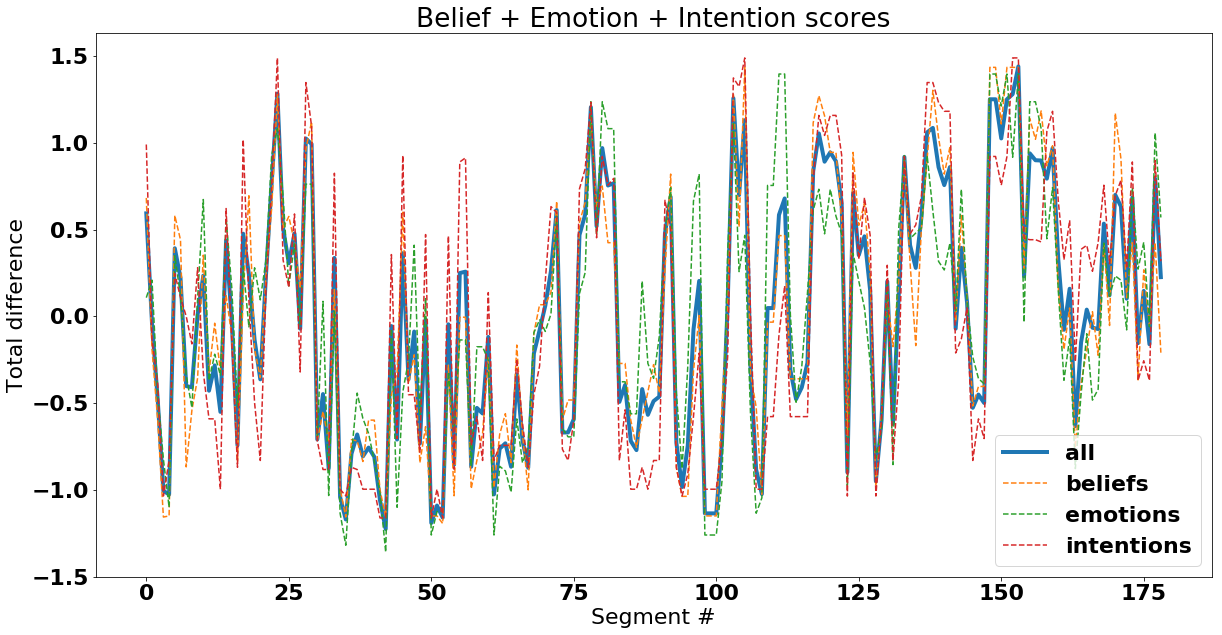

In [13]:
plt.figure(figsize=(20,10))

plt.plot(segment_score/3, label='all',linewidth=4)
plt.plot(mean_beliefs, '--', label='beliefs')
plt.plot(mean_emotions, '--', label='emotions')
plt.plot(mean_intentions, '--', label='intentions')

plt.legend(loc=4)
plt.xlabel('Segment #')
plt.ylabel('Total difference')
plt.title('Belief + Emotion + Intention scores')
plt.show()



In [14]:
sorted_ind = np.argsort(segment_score)
sorted_beliefs = np.argsort(mean_beliefs)
sorted_emotions = np.argsort(mean_emotions)
sorted_intentions = np.argsort(mean_intentions)

In [15]:
# now we have to get accompanying TR - subtract 1 for python indices
TR_onset = data['from TR (TR=1 is at time21sec of theaudio file)'][r1:r2].as_matrix() - 1 
TR_offset = data['to TR'][r1:r2].as_matrix() - 1 
total_trs_seg = TR_offset - TR_onset + 1
total_trs_seg[np.argwhere(total_trs_seg==0)]=1

/jukebox/pkgs/PYGER/beta/lib/python3.6/site-packages/ipykernel/__main__.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app
/jukebox/pkgs/PYGER/beta/lib/python3.6/site-packages/ipykernel/__main__.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()


In [16]:
# do a different way -- combine TR numbers and make sure TRs are unique before combining and counting!!
all_low_diff = []
all_high_diff = []
onset_sorted = TR_onset[sorted_ind]
sorted_total_trs = total_trs_seg[sorted_ind]
tend = 97
for t in np.arange(tend):
    tr_onset = onset_sorted[t]
    #print(tr_onset)
    if sorted_total_trs[t] > 1:
        tr_included = np.arange(tr_onset,tr_onset+sorted_total_trs[t])
        tr_included = tr_included.tolist()
        all_low_diff.extend(tr_included)
    else:
        tr_included = tr_onset
        all_low_diff.append(tr_included)
    all_low_diff = np.unique(all_low_diff).tolist()
print(all_low_diff)
print(len(all_low_diff))

# now add the high diff ones
for t in np.arange(tend,len(sorted_ind)):
    tr_onset = onset_sorted[t]
    #print(tr_onset)
    if sorted_total_trs[t] > 1:
        tr_included = np.arange(tr_onset,tr_onset+sorted_total_trs[t])
        tr_included = tr_included.tolist()
        all_high_diff.extend(tr_included)
    else:
        tr_included = tr_onset
        all_high_diff.append(tr_included)
    all_high_diff = np.unique(all_high_diff).tolist()
print(all_high_diff)
print(len(all_high_diff))
all_low_int = np.asarray(all_low_diff).astype(int)
all_high_int = np.asarray(all_high_diff).astype(int)

[5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 57.0, 58.0, 59.0, 63.0, 64.0, 65.0, 66.0, 67.0, 80.0, 81.0, 87.0, 88.0, 89.0, 90.0, 91.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0, 109.0, 110.0, 117.0, 118.0, 119.0, 120.0, 121.0, 122.0, 123.0, 124.0, 125.0, 126.0, 127.0, 128.0, 129.0, 130.0, 131.0, 132.0, 133.0, 134.0, 135.0, 136.0, 137.0, 138.0, 139.0, 140.0, 145.0, 146.0, 147.0, 148.0, 149.0, 150.0, 151.0, 152.0, 153.0, 154.0, 155.0, 156.0, 157.0, 158.0, 159.0, 160.0, 161.0, 162.0, 163.0, 164.0, 165.0, 166.0, 167.0, 168.0, 169.0, 170.0, 171.0, 172.0, 173.0, 174.0, 183.0, 184.0, 185.0, 186.0, 187.0, 188.0, 189.0, 190.0, 212.0, 213.0, 214.0, 215.0, 216.0, 217.0, 218.0, 219.0, 220.0, 221.0, 222.0, 223.0, 224.0, 225.0, 226.0, 227.0, 228.0, 229.0, 2

In [17]:
# do a different way -- combine TR numbers and make sure TRs are unique before combining and counting!!
all_low_diff_emotions = []
all_high_diff_emotions = []
onset_sorted = TR_onset[sorted_emotions]
sorted_total_trs = total_trs_seg[sorted_emotions]
tend = 96
for t in np.arange(tend):
    tr_onset = onset_sorted[t]
    #print(tr_onset)
    if sorted_total_trs[t] > 1:
        tr_included = np.arange(tr_onset,tr_onset+sorted_total_trs[t])
        tr_included = tr_included.tolist()
        all_low_diff_emotions.extend(tr_included)
    else:
        tr_included = tr_onset
        all_low_diff_emotions.append(tr_included)
    all_low_diff_emotions = np.unique(all_low_diff_emotions).tolist()
print(all_low_diff_emotions)
print(len(all_low_diff_emotions))

# now add the high diff ones
for t in np.arange(tend,len(sorted_ind)):
    tr_onset = onset_sorted[t]
    #print(tr_onset)
    if sorted_total_trs[t] > 1:
        tr_included = np.arange(tr_onset,tr_onset+sorted_total_trs[t])
        tr_included = tr_included.tolist()
        all_high_diff_emotions.extend(tr_included)
    else:
        tr_included = tr_onset
        all_high_diff_emotions.append(tr_included)
    all_high_diff_emotions = np.unique(all_high_diff_emotions).tolist()
print(all_high_diff_emotions)
print(len(all_high_diff_emotions))
all_low_int_emotions = np.asarray(all_low_diff_emotions).astype(int)
all_high_int_emotions = np.asarray(all_high_diff_emotions).astype(int)

[14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 59.0, 62.0, 65.0, 66.0, 67.0, 80.0, 81.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0, 109.0, 110.0, 111.0, 112.0, 113.0, 114.0, 115.0, 116.0, 117.0, 118.0, 119.0, 120.0, 124.0, 125.0, 126.0, 129.0, 130.0, 131.0, 132.0, 133.0, 134.0, 135.0, 136.0, 137.0, 138.0, 139.0, 140.0, 141.0, 142.0, 143.0, 144.0, 145.0, 146.0, 147.0, 148.0, 149.0, 150.0, 151.0, 152.0, 153.0, 154.0, 155.0, 156.0, 157.0, 158.0, 159.0, 160.0, 161.0, 162.0, 163.0, 164.0, 165.0, 166.0, 167.0, 168.0, 169.0, 170.0, 171.0, 172.0, 173.0, 174.0, 175.0, 176.0, 177.0, 183.0, 184.0, 185.0, 186.0, 187.0, 188.0, 189.0, 190.0, 212.0, 213.0, 214.0, 215.0, 216.0, 217.0, 218.0, 219.0, 220.0, 222.0, 223.0, 224.0, 225.0, 226.0, 227.0, 228.0, 229.0, 230.0, 241.0, 242.0, 243.

In [18]:
nTRs = 452
z = np.append(all_low_diff,all_high_diff)
np.shape(z)
u = np.unique(z)
np.shape(u) # 2 TRs overlap

(450,)

In [19]:
# convert segment scores to TR numbers ***
segment_score_vector = -100 * np.ones((450))
beliefs_vector = -100 * np.ones((450))
emotions_vector = -100 * np.ones((450))
intentions_vector = -100 * np.ones((450))
for t in np.arange(len(TR_onset)):
    tr_onset = TR_onset[t]
    #print(tr_onset)
    if total_trs_seg[t] > 1:
        tr_included = np.arange(tr_onset,tr_onset+total_trs_seg[t]).astype(int)
        n = np.shape(tr_included)[0]
    else:
        tr_included = np.array([tr_onset.astype(int)])
        n = 1
    for z in np.arange(n):
        tr_index = tr_included[z]
        if segment_score_vector[tr_index] == -100:
            segment_score_vector[tr_index] = segment_score[t]
        if beliefs_vector[tr_index] == -100:
            beliefs_vector[tr_index] = mean_beliefs[t]
        if emotions_vector[tr_index] == -100:
            emotions_vector[tr_index] = mean_emotions[t]
        if intentions_vector[tr_index] == -100:
            intentions_vector[tr_index] = mean_intentions[t]
    #print(n)
    #print(tr_index)

In [20]:
# make array for high/low
high_trs = -4 * np.ones((450,))
high_trs[all_high_int] = 4
high_trs_b = -4 * np.ones((450,))
high_trs_b[all_high_int_beliefs] = 4
high_trs_e = -4 * np.ones((450,))
high_trs_e[all_high_int_emotions] = 4

NameError: name 'all_high_int_beliefs' is not defined

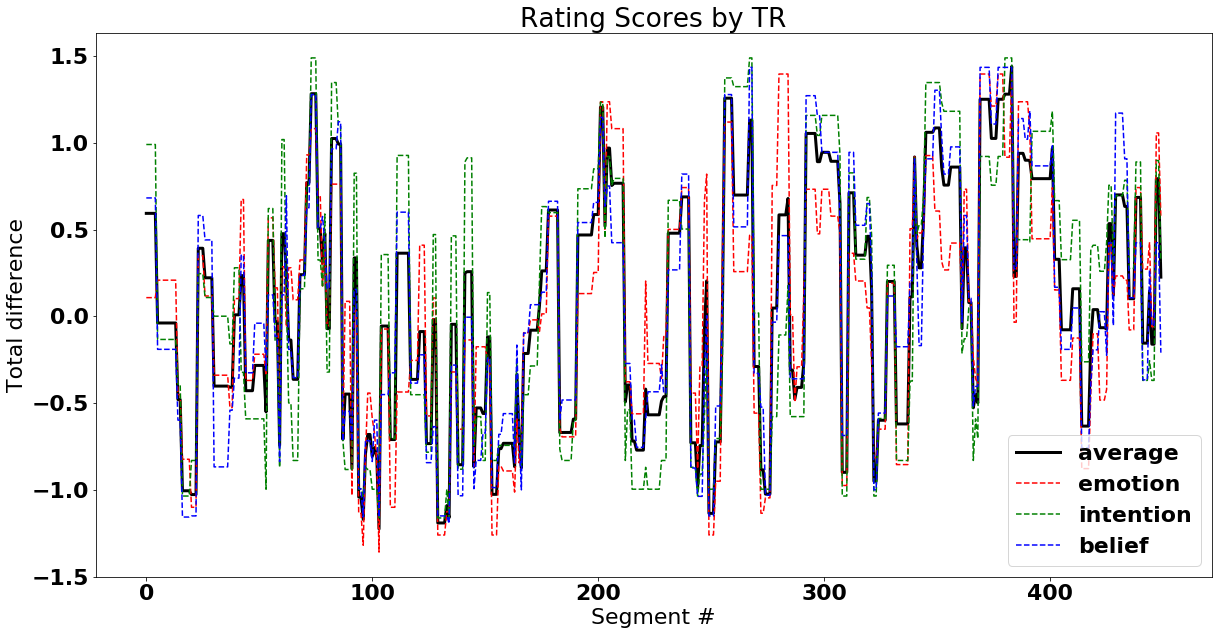

In [29]:
# now plot the two categories along with the scores
# plot TR on the x axis instead of segment number
plt.figure(figsize=(20,10))
plt.plot(segment_score_vector/3, 'k' ,linewidth=3,label='average')
plt.plot(emotions_vector, '--r', label='emotion')
plt.plot(intentions_vector, '--g', label='intention')
plt.plot(beliefs_vector, '--b',label='belief')
#plt.plot(high_trs, '.')
#plt.plot(high_trs_e, 'g.')
plt.legend(loc=4)
plt.xlabel('Segment #')
plt.ylabel('Total difference')
plt.title('Rating Scores by TR')
plt.show()

In [20]:
# now save all the TRs into matrices!
#np.save('all_high_difference_trs.npy', all_high_int)
#np.save('all_low_difference_trs.npy', all_low_int)

In [38]:
all_high_int

array([  0,   1,   2,   3,   4,  23,  24,  25,  26,  27,  28,  29,  42,
        43,  54,  55,  56,  60,  61,  62,  68,  69,  70,  71,  72,  73,
        74,  75,  76,  77,  78,  79,  82,  83,  84,  85,  86,  92,  93,
       111, 112, 113, 114, 115, 116, 141, 142, 143, 144, 175, 176, 177,
       178, 179, 180, 181, 182, 191, 192, 193, 194, 195, 196, 197, 198,
       199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211,
       231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 248, 256, 257,
       258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 279, 280,
       281, 282, 283, 284, 291, 292, 293, 294, 295, 296, 297, 298, 299,
       300, 301, 302, 303, 304, 305, 306, 307, 311, 312, 313, 314, 315,
       316, 317, 318, 319, 320, 321, 328, 329, 330, 331, 338, 339, 340,
       341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353,
       354, 355, 356, 357, 358, 359, 360, 362, 363, 364, 365, 369, 370,
       371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 38

In [16]:
np.diff(all_high_int)
slice_info = {}

slice_info['start'] = np.array([0,23,68,82,111,175,191,231,256,279,291,311,338,369,426])
slice_info['end'] = np.array([4,29,79,86,116,182,211,240,268,284,307,321,360,404,440])
slice_info['duration'] = slice_info['end'] - slice_info['start'] + 1

nslices = np.shape(slice_info['duration'])[0]
# length of sections 5 +:
# 0-4, 23-29, 68-79, 82-86, 111-116, 175-182, 191-211, 231-240, 256-268, 279-284, 291-307, 311-321, 338-360, 369-404, 426-440

# make slice vector
slice_vector = -8 *np.ones((450,))
for s in np.arange(nslices):
    start = slice_info['start'][s]
    end = slice_info['end'][s]
    dur = slice_info['duration'][s]
    print(dur)
    if dur >= 7:
        slice_vector[start:end+1] = 4


5
7
12
5
6
8
21
10
13
6
17
11
23
36
15


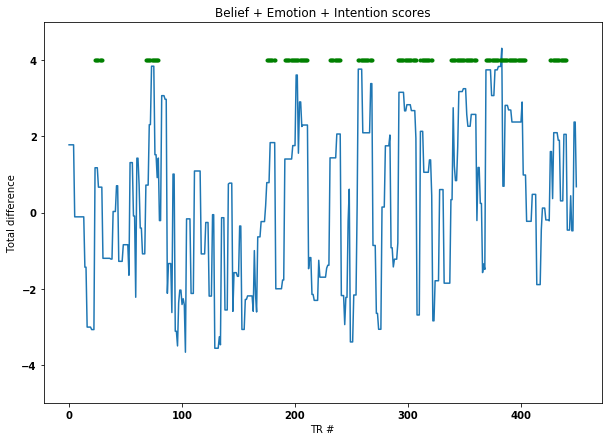

In [17]:
plt.figure(figsize=(10,7))
plt.plot(segment_score_vector)
plt.plot(slice_vector, 'g.')
plt.xlabel('TR #')
plt.ylim([-5,5])
plt.ylabel('Total difference')
plt.title('Belief + Emotion + Intention scores')
plt.show()

In [22]:
#np.save('segment_score_vector.npy', segment_score_vector)
np.save('emotions_vector.npy', emotions_vector)
np.save('beliefs_vector.npy', beliefs_vector)
np.save('intentions_vector.npy', intentions_vector)

In [41]:
g=( '0-4', 23-29, 68-79, 82-86, 111-116, 175-182, 191-211, 231-240, 256-268, 279-284, 291-307, 311-321, 338-360, 369-404, 426-440)

In [42]:
g

('0-4', -6, -11, -4, -5, -7, -20, -9, -12, -5, -16, -10, -22, -35, -14)

In [22]:
nTR=475
trigger_times = np.arange(0,714,1.5)
t = 21
np.argwhere(np.min(np.abs(trigger_times-t)))
trigger_times

array([  0. ,   1.5,   3. ,   4.5,   6. ,   7.5,   9. ,  10.5,  12. ,
        13.5,  15. ,  16.5,  18. ,  19.5,  21. ,  22.5,  24. ,  25.5,
        27. ,  28.5,  30. ,  31.5,  33. ,  34.5,  36. ,  37.5,  39. ,
        40.5,  42. ,  43.5,  45. ,  46.5,  48. ,  49.5,  51. ,  52.5,
        54. ,  55.5,  57. ,  58.5,  60. ,  61.5,  63. ,  64.5,  66. ,
        67.5,  69. ,  70.5,  72. ,  73.5,  75. ,  76.5,  78. ,  79.5,
        81. ,  82.5,  84. ,  85.5,  87. ,  88.5,  90. ,  91.5,  93. ,
        94.5,  96. ,  97.5,  99. , 100.5, 102. , 103.5, 105. , 106.5,
       108. , 109.5, 111. , 112.5, 114. , 115.5, 117. , 118.5, 120. ,
       121.5, 123. , 124.5, 126. , 127.5, 129. , 130.5, 132. , 133.5,
       135. , 136.5, 138. , 139.5, 141. , 142.5, 144. , 145.5, 147. ,
       148.5, 150. , 151.5, 153. , 154.5, 156. , 157.5, 159. , 160.5,
       162. , 163.5, 165. , 166.5, 168. , 169.5, 171. , 172.5, 174. ,
       175.5, 177. , 178.5, 180. , 181.5, 183. , 184.5, 186. , 187.5,
       189. , 190.5,

In [32]:
t=1
TRnum = np.argmin(np.abs(trigger_times-t)) 
print(TRnum)

1


In [64]:
convertTR(0,694,1.5)

462

In [54]:
def convertTR(onsetTime,offsetTime,TRlength):
#offsetTime = time of actual stimulus
#onsetTime is begginging of your counter
    dt = offsetTime - onsetTime;
    TRnumber = np.floor(dt/TRlength)  # remove + 1 because of python
    return np.int(TRnumber)

In [31]:
trigger_times[291]

436.5